In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
import os

os.sys.path.append(os.path.dirname(os.path.abspath('.')))

from util import model_utils
from util.attribution_methods import saliencyMethods as attr
from util.attribution_methods import GIGBuilder as GIG_Builder
from util.attribution_methods import AGI as AGI

model = models.resnet101(weights = "ResNet101_Weights.IMAGENET1K_V2")
model = model.eval()
model.to("cuda:0")

# standard image resize dimension for ResNet
img_hw = 224

# transforms for IG, LIG, and IDG
transform = transforms.Compose([
     transforms.Resize((img_hw, img_hw)),
     transforms.CenterCrop(img_hw),
     transforms.ToTensor()
])

# standard ImageNet normalization for IG, LIG, and IDG
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

# transforms and normalization for GIG and AGI
resize = transforms.Resize((img_hw, img_hw))
crop = transforms.CenterCrop(img_hw)
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# color map for Captum attribution visualization
default_cmap = LinearSegmentedColormap.from_list('custom blue',  [(0, '#ffffff'), (0.25, '#0000ff'), (1, '#0000ff')], N = 256)   

<h1>Load an image and get the class</h1>

65.27093648910522 warplane


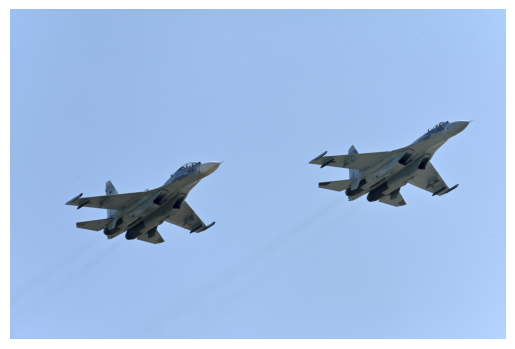

In [2]:
image_path = "img/jet.jpg"
img = Image.open(image_path)

trans_img = transform(img)
input_img = normalize(trans_img).unsqueeze(0)

device = "cuda:0"

target_class = model_utils.getClass(input_img, model, device)
# open the class list so the detected class string can be returned for printing
with open('../util/class_maps/ImageNet/imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]
name = classes[target_class]
print(model_utils.getPrediction(input_img, model, device, target_class)[0] * 100, name)

plt.axis("off")
plt.imshow(img)
plt.show()

<h1>Generate attributions</h1>

In [3]:
steps = 50
batch_size = 25
baseline = 0

In [4]:
# alpha star = 1, plain IG attribution
ig = attr.IG(input_img, model, steps, batch_size, 1, 0, device, target_class)

In [5]:
# alpha star = 0.9, Left IG attribution
lig = attr.IG(input_img, model, steps, batch_size, .9, 0, device, target_class)

In [6]:
# get integrated decision gradients attribution
idg = attr.IDG(input_img, model, steps, batch_size, 0, device, target_class)

In [8]:
call_model_args = {'class_idx_str': target_class.item()}
guided_ig = GIG_Builder.GuidedIG()
baseline = torch.zeros_like(input_img)
gig = guided_ig.GetMask(input_img, model, device, GIG_Builder.call_model_function, call_model_args, x_baseline=baseline, x_steps=50, max_dist=1.0, fraction=0.5)

In [9]:
epsilon = 0.05
topk = 1
max_iter = 20
agi_img = AGI.LoadImage(image_path, resize, crop)
agi_img = agi_img.astype(np.float32) 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
norm_layer = AGI.Normalize(mean, std)
modified_model = nn.Sequential(norm_layer, model).to(device)        
selected_ids = range(0, 999, int(1000 / topk))

_, _, agi = AGI.test(modified_model, device, agi_img, epsilon, topk, selected_ids, max_iter)

# perform AGI thresholding 
percentile = 80
upperbound = 99
hm = agi
hm = np.mean(hm, axis=0)
q = np.percentile(hm, percentile)
u = np.percentile(hm, upperbound)
hm[hm<q] = q
hm[hm>u] = u
hm = (hm-q)/(u-q)

# AGI attribution
agi = np.reshape(hm, (img_hw, img_hw, 1))

<h1>Visualize the attributions </h1>

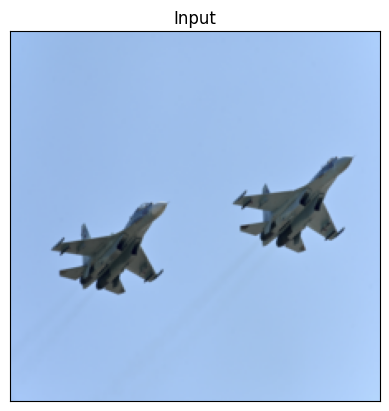

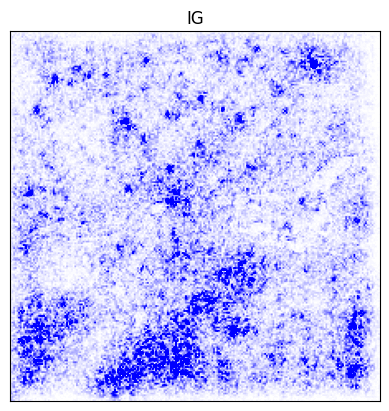

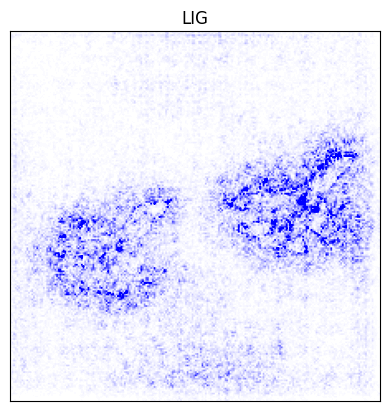

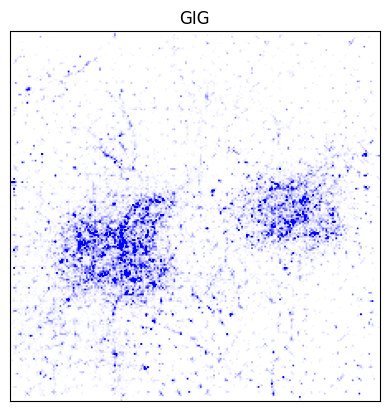

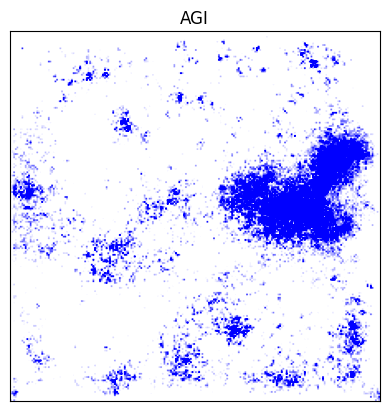

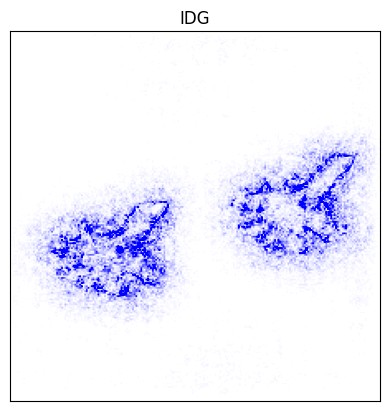

In [11]:
# transform the [C, H, W] image and attributions to [H, W, C] for display
img_print = np.transpose(trans_img.squeeze().detach().cpu().numpy(), (1, 2, 0))
ig_print = np.transpose(ig.squeeze().detach().cpu().numpy(), (1,2,0))
lig_print = np.transpose(lig.squeeze().detach().cpu().numpy(), (1,2,0))
idg_print = np.transpose(idg.squeeze().detach().cpu().numpy(), (1,2,0))
gig_print = np.transpose(gig.squeeze().detach().cpu().numpy(), (1, 2, 0))
agi_print = agi

fig, _ = viz.visualize_image_attr(None, img_print, 
                    method="original_image",
                    title="Input",
                    plt_fig_axis = plt.subplots(1, 1))

fig, _ = viz.visualize_image_attr(ig_print,
                            img_print,
                            method='heat_map',
                            title="IG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))

fig, _ = viz.visualize_image_attr(lig_print,
                            img_print,
                            method='heat_map',
                            title="LIG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(gig_print,
                            img_print,
                            method='heat_map',
                            title="GIG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(agi_print,
                            img_print,
                            method='heat_map',
                            title="AGI",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))


fig, _ = viz.visualize_image_attr(idg_print,
                            img_print,
                            method='heat_map',
                            title="IDG",
                            cmap=default_cmap,
                            sign='absolute_value',
                            plt_fig_axis = plt.subplots(1, 1))